In [1]:
#import packages
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#preprocessing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# various layers
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras.models import Model
from keras import layers
#regularizer
from keras.regularizers import l2
#pandas
import pandas as pd
#opencv
import cv2
#numpy
import numpy as np

In [2]:
#this is the path where the csv file is stored
dataset_path = 'fer2013.csv' 

In [3]:
#for resizing of the input images to 48X48 pixels
total_image_size=(48,48)

In [4]:
#function for loading the dataset
def load_dataset():
    #reads the csv file
    storeCSVData = pd.read_csv("fer2013.csv")
    #to get the pixels of the image data
    getPixels = storeCSVData["pixels"].tolist()
    #defining the width and heigh
    widthSize, heightSize = 48, 48
    #array to store all the images with closeup faces
    facesArray = []
    #iterating over every pixel
    for pixel_sequence in getPixels:
        #splitiing the pixel value
        face = [int(getPixels) for getPixels in pixel_sequence.split(' ')]
        #and reshaping it to the defined width and height
        face = np.asarray(face).reshape(widthSize, heightSize)
        #data vectorization
        face = cv2.resize(face.astype('uint8'),total_image_size)
        #appending the reshaped and resized image into faces array
        facesArray.append(face.astype('float32'))
    #storing the numpy data as array    
    facesArray = np.asarray(facesArray)
    facesArray = np.expand_dims(facesArray, -1)
    #creating a label called emotion 
    emotions = pd.get_dummies(storeCSVData['emotion']).values
    #return the images and labels
    return facesArray, emotions

In [5]:
#for preprocessing the data
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [6]:
#calling the load function
facesArray, emotions = load_dataset()
#poassing the array as function parameter for preprocessing
faces = preprocess_input(facesArray)
#for training and storing the data sets 20% separated for validation rest for training
xtrain, xtest,ytrain,ytest = train_test_split(facesArray, emotions,test_size=0.2,shuffle=True) 

In [7]:
#defining the total number of images to be tested at once
batch_size = 32 
#total number of iterations for training
num_epochs = 50 
input_shape = (48, 48, 1) # (h, W, gray)
#for showing training progress
verbose = 1
#total number of classes which are angry, happy, neutral, sad, surprise, disgust and fear
num_classes = 7 
#number of epochs with no improvement in learning rate
patience = 7 
base_path = 'models/'
#for regularizing the data
l2_regularization=0.01

In [8]:
 
#for regularizing data, l2 regularization is being used
regularization = l2(l2_regularization)

In [9]:
#input layer
img_input = Input(input_shape)
#convolutional layer with regularizers
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
#normalize the data
x = BatchNormalization()(x) 
#convolutional layer with regularizers
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
#activation function relu used
x = Activation('relu')(x)

In [10]:
#module 1
#defining residual for normalization with keeping the padding as same as needed for no pixel loss during convolution
residual = Conv2D(64, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
#separable 2D convolutional layer with 64
x = SeparableConv2D(64, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

#module 2
#defining residual for normalization with keeping the padding as same as needed for no pixel loss during convolution
residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(256, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(256, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(256, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 4
residual = Conv2D(512, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(512, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
#relu activation function
x = Activation('relu')(x)
x = SeparableConv2D(512, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 5
residual = Conv2D(512, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(512, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
#normalize the data
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(512, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
#softmax activation finction
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
# callbacks
log_file_path = 'trytrytry.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = 'trytrytry' + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
 
history = model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=15, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/15
897/897 [==============================] - 629s 701ms/step - loss: 0.9221 - accuracy: 0.6568 - val_loss: 0.9861 - val_accuracy: 0.6317

Epoch 00001: val_loss improved from inf to 0.98609, saving model to trytrytry.01-0.63.hdf5
Epoch 2/15
897/897 [==============================] - 628s 700ms/step - loss: 0.9196 - accuracy: 0.6582 - val_loss: 0.9854 - val_accuracy: 0.6328

Epoch 00002: val_loss improved from 0.98609 to 0.98536, saving model to trytrytry.02-0.63.hdf5
Epoch 3/15
897/897 [==============================] - 623s 695ms/step - loss: 0.9187 - accuracy: 0.6596 - val_loss: 0.9829 - val_accuracy: 0.6349

Epoch 00003: val_loss improved from 0.98536 to 0.98292, saving model to trytrytry.03-0.63.hdf5
Epoch 4/15
897/897 [==============================] - 625s 697ms/step - loss: 0.9184 - accuracy: 0.6579 - val_loss: 0.9826 - val_accuracy: 0.6351

Epoch 00004: val_loss improved from 0.98292 to 0.98255, saving model to trytrytry.04-0.64.hdf5
Epoch 5/15
897/897 [================

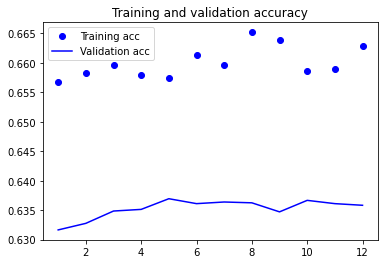

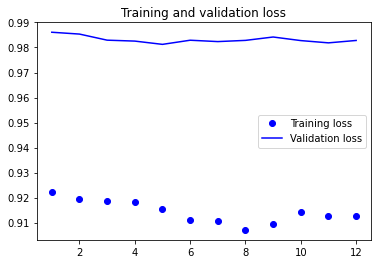

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
#shown for last few epochs when 15 extra were added 
#the previous training graphs have been compiled in the report

angry [1.0000000e+02 0.0000000e+00 1.7315493e-25 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


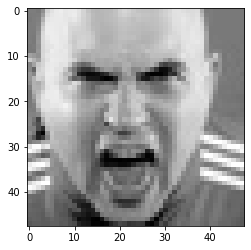

In [10]:
#####-----TO TEST STATIC IMAGES

#importing load_model to load the created model
from keras.models import load_model
#importing image as array
from keras.preprocessing.image import img_to_array
#to import image
from keras.preprocessing import image
#open cv for face detection
import cv2 as cv2
#numpy array
import numpy as np
#to display the image
import matplotlib.pyplot as plot
#loading the model
classifier= load_model(r'E:\Study\Year 3\Term I\Artificial Intelligence\Assignment\face-expression-recognition-dataset\images\final_model.hdf5')

#a test image
image_test = cv2.imread('angry.jpg', 0)
image_test.shape
#resizing the test image
image_test = cv2.resize(image_test, (48,48))
#to show the image
plot.imshow(image_test,cmap='gray')
#array for labels
emotion_labels =['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
image_test = image_test.reshape(1,48,48,1)
#for showing the predictions
predictions = classifier.predict(image_test)[0]
received_label =emotion_labels[predictions.argmax()]
print(received_label, predictions*100)

In [11]:
#####-----LIVE VIDEO TESTING

face_classifier = cv2.CascadeClassifier(r'E:\Study\Year 3\Term I\Artificial Intelligence\Assignment\face-expression-recognition-dataset\images\haarcascade_frontalface_default.xml')

classifier= load_model(r'E:\Study\Year 3\Term I\Artificial Intelligence\Assignment\face-expression-recognition-dataset\images\final_model.hdf5')
class_labels =['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [12]:
capture_video = cv2.VideoCapture(0)

In [13]:
while True:
    # Grab a single frame of video
    ret, frame = capture_video.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray,1.3,5)
    #loop through the pixels of image
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)


        #preprocess the image
        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

        # make a prediction on the ROI, then lookup the class
            predictions = classifier.predict(roi)[0]
            label=class_labels[predictions.argmax()]
            label_position = (x,y)
            #frame and text on the captured video
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(120,115,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(120,115,0),3)
    cv2.imshow('Emotion Detector',frame)
    #press s to exit
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
#error handling
capture_video.release()
cv2.destroyAllWindows()